In [1]:
import warnings
from src.utils_functions import *

# Display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_theme(context='notebook', style=plt.style.use('dark_background'))
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# Carga y lectura de los datos
data = pd.read_excel('datasets\\raw\\IPC_India.xlsx',
                     skiprows=list(range(5)),
                     usecols=['Fecha', 'Índice', 'Mensual'],
                     index_col=[0])
data.columns = ['IPC', 'Retornos']
data

,IPC,Retornos
Fecha,,
2013-02-01,100.67,0.67
2013-03-01,100.86,0.19
2013-04-01,101.44,0.57
2013-05-01,102.20,0.75
2013-06-01,104.50,2.25
...,...,...
2023-03-01,169.44,0.23
2023-04-01,170.31,0.51
2023-05-01,171.26,0.56


In [3]:
# Definimos la frecuencia de nuestras series temporales
data = data.asfreq('MS')
data.index

DatetimeIndex(['2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01',
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01',
               ...
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01'],
              dtype='datetime64[ns]', name='Fecha', length=126, freq='MS')

In [4]:
# Estadísticos descriptivos
data.describe().T

,count,mean,std,min,25%,50%,75%,max
IPC,126.00,134.67,19.73,100.67,120.03,131.68,149.90,178.15
Retornos,126.00,0.46,0.67,-1.55,0.07,0.47,0.87,2.93


In [5]:
# Estadísticos descriptivos
data.reset_index()[['Fecha']].describe()

,Fecha
count,126
mean,2018-04-16 16:22:51.428571392
min,2013-02-01 00:00:00
25%,2015-09-08 12:00:00
50%,2018-04-16 00:00:00
75%,2020-11-23 12:00:00
max,2023-07-01 00:00:00


In [6]:
# Valores faltantes
data.isnull().sum()

IPC         0
Retornos    0
dtype: int64

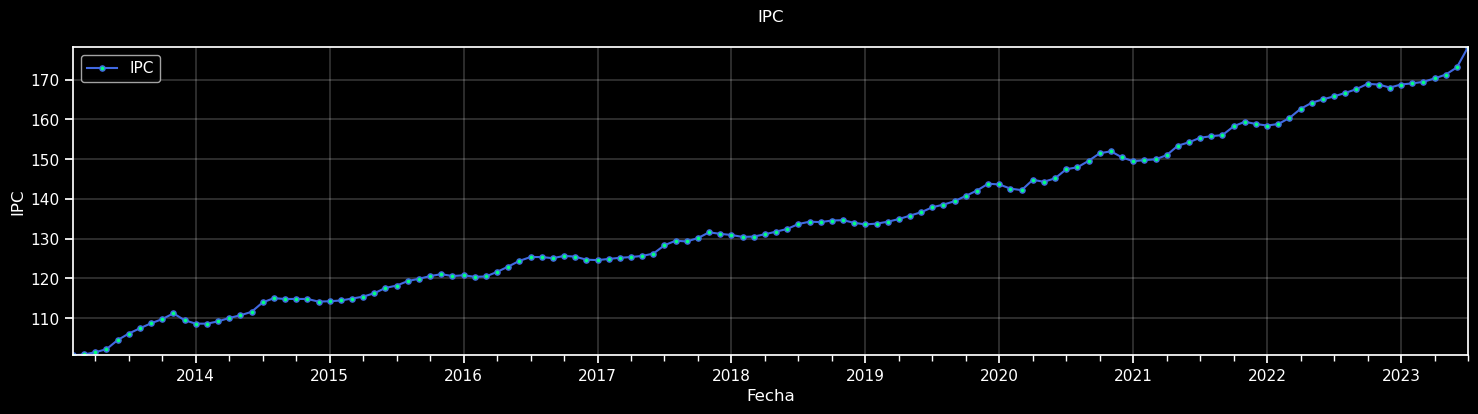

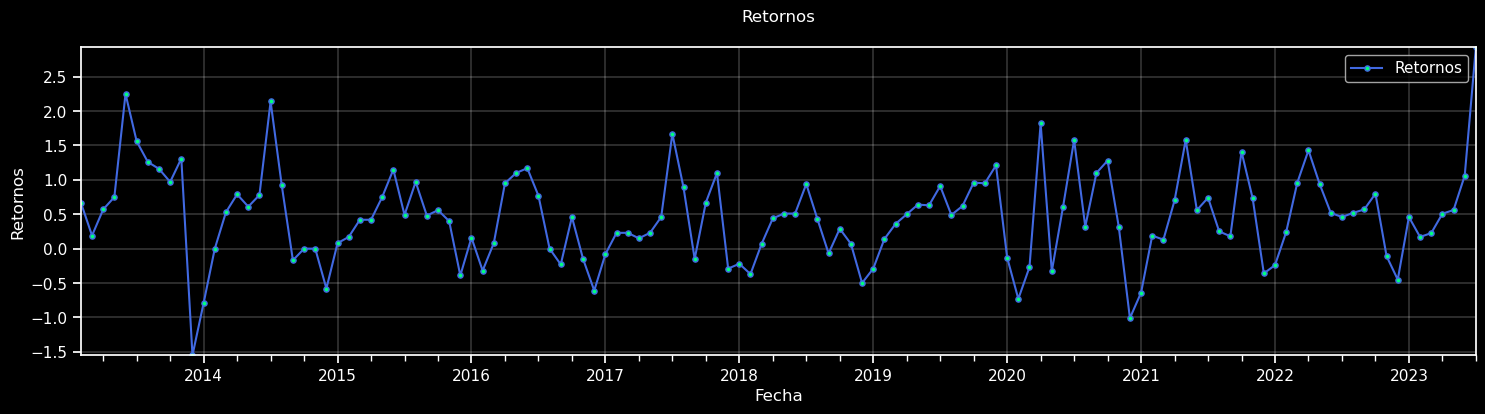

In [7]:
# Graficar el comportamiento de las series de tiempo
time_series_behavior(data=data)

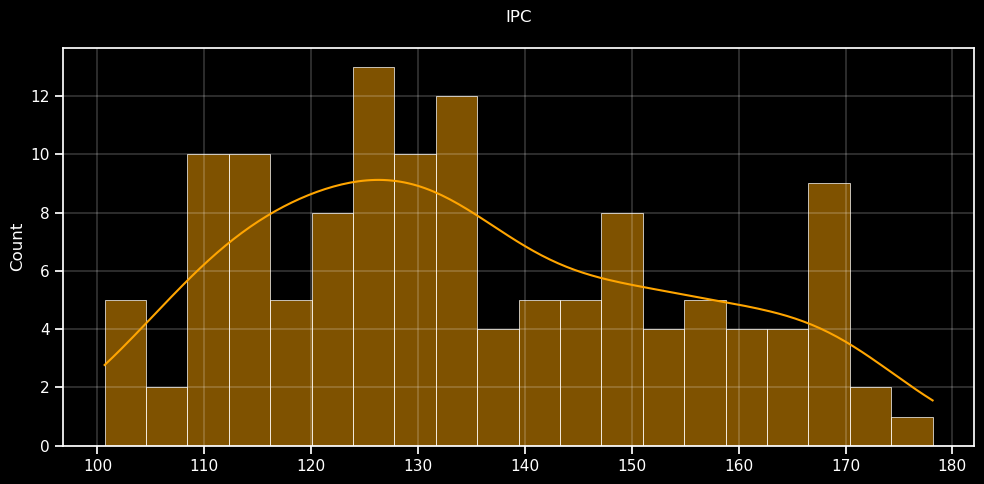

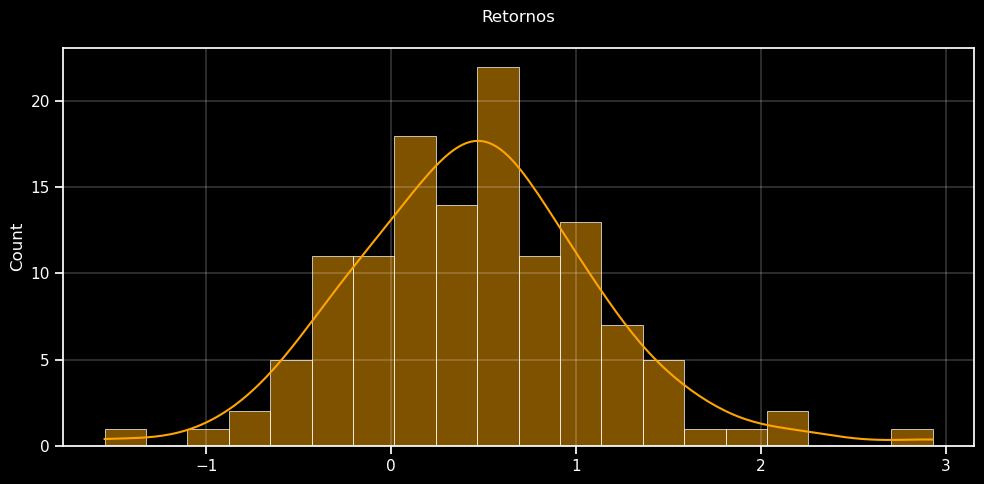

In [8]:
# Graficar la distribución de las series de tiempo
time_series_behavior(data=data, kind='histplot')

### *Estacionalidad*

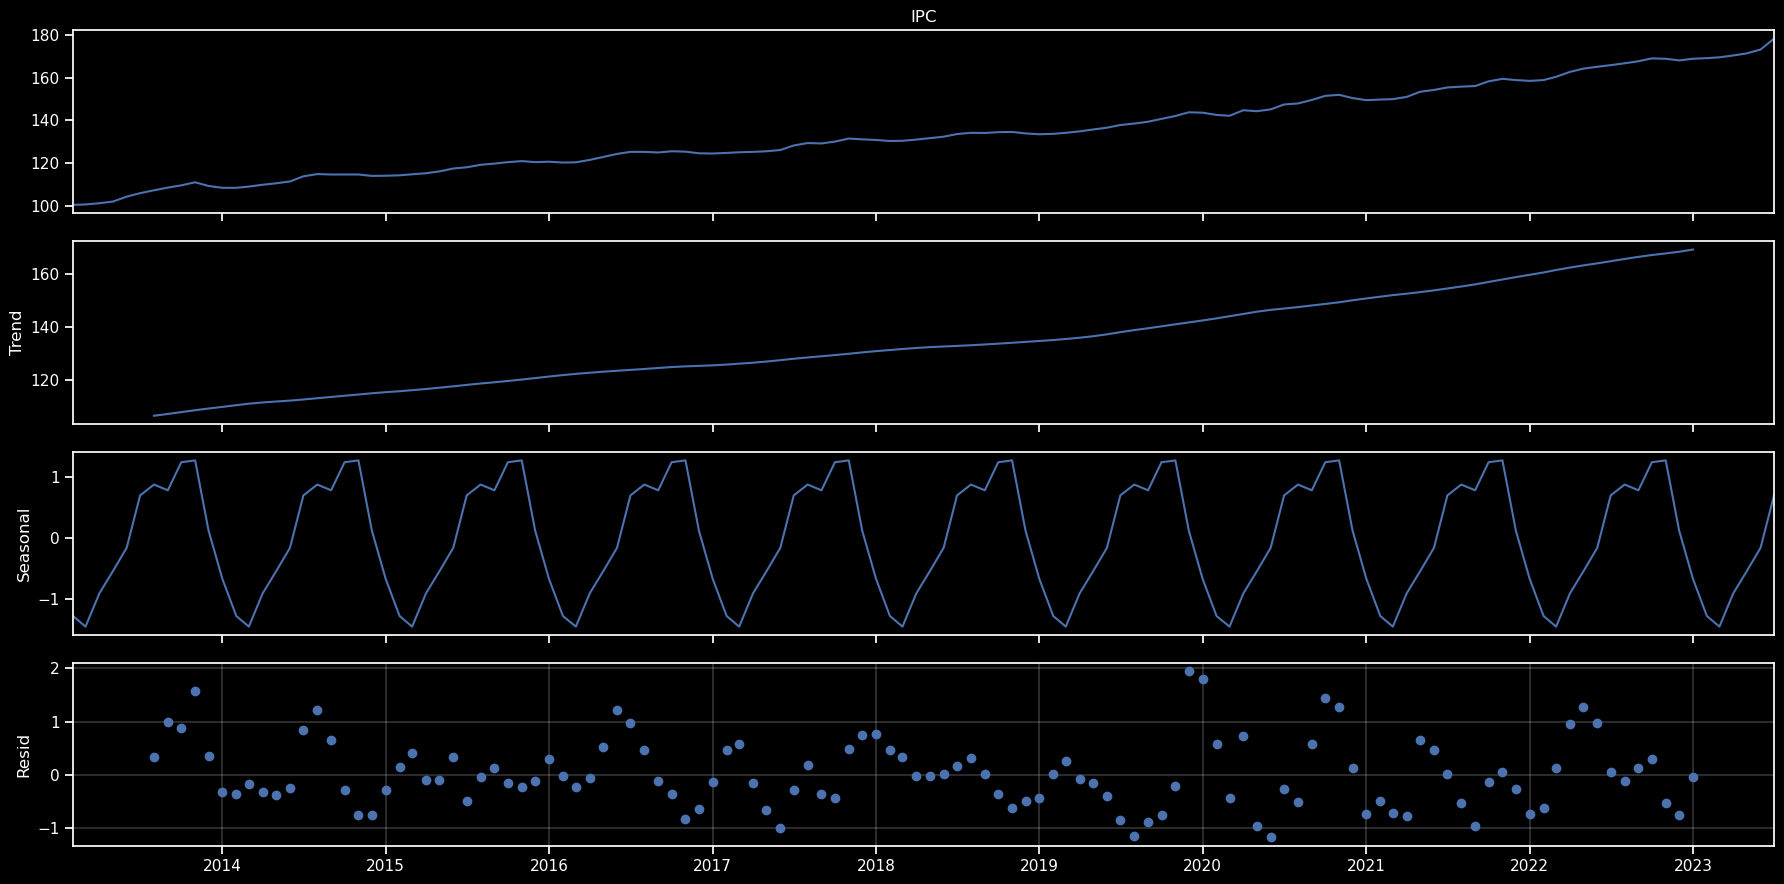

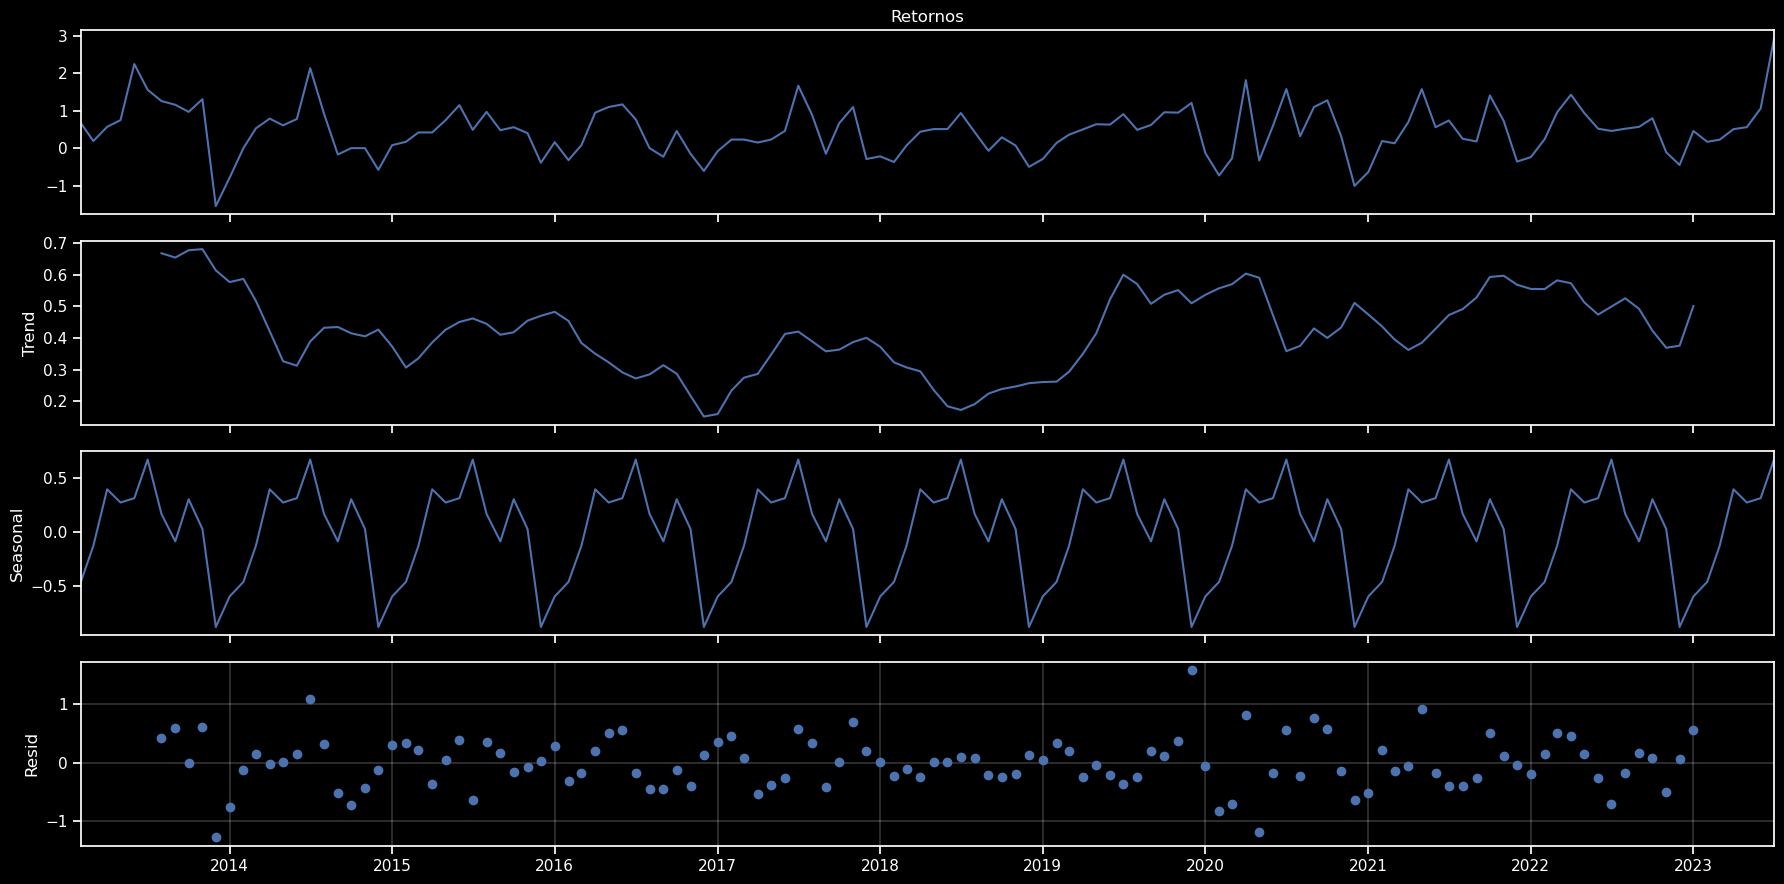

In [9]:
# Descomposición de las series de tiempo
for serie in data.columns:
    result = seasonal_decompose(data[serie], model='additive').plot().set_size_inches((18, 9))
    plt.grid(color='white', linestyle='-', linewidth=0.25)
    plt.tight_layout()
    plt.show()

In [10]:
from statsmodels.tsa.seasonal import STL

# Crea un DataFrame vacío para almacenar los datos desestacionalizados
data_deseasoned = pd.DataFrame()
residuos = pd.DataFrame()

# Apply STL decomposition
for serie in data.columns:
    res = STL(data[serie], robust=True).fit()
    seasonal_component = res.seasonal
    data_deseasoned[serie] = (data[serie] - seasonal_component)
    residuos[serie] = res.resid

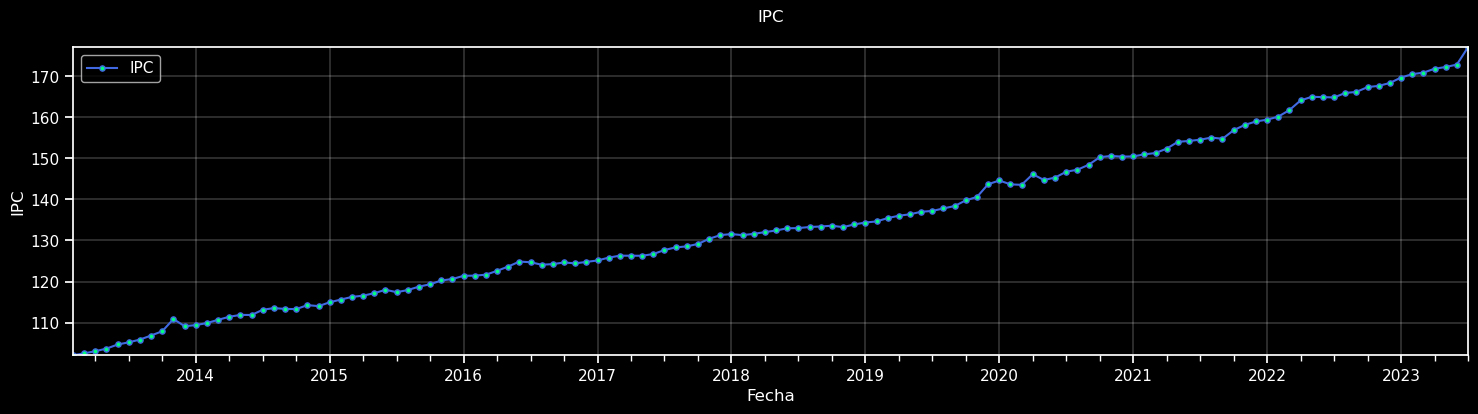

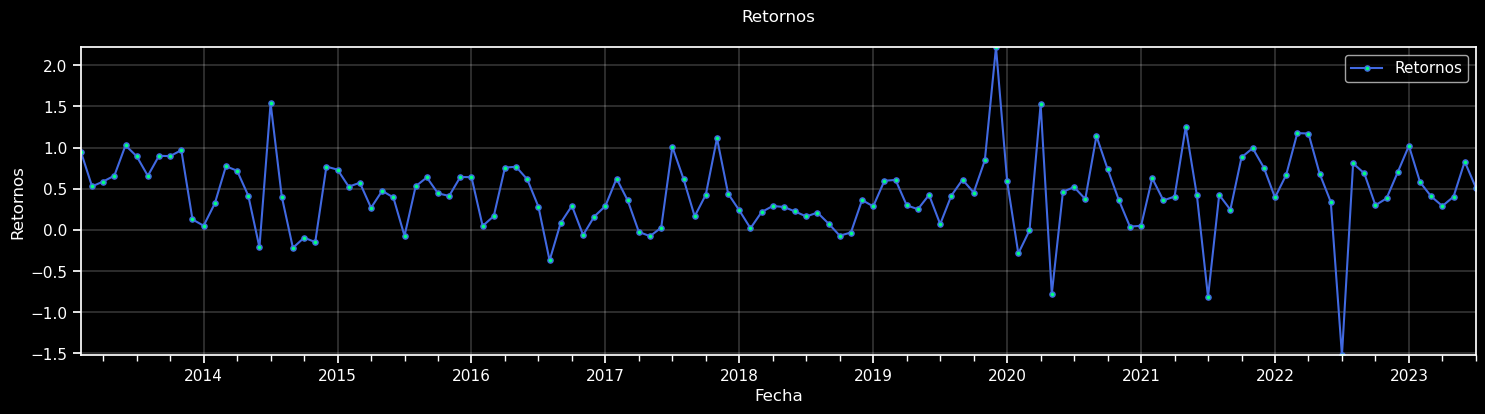

In [11]:
# Graficar las series de tiempo desestacionalizadas
time_series_behavior(data=data_deseasoned)

### **La desviación absoluta de la mediana (MAD)**

La mediana puede utilizarse en lugar de la media para proporcionar un valor robusto de valores atípicos para el valor esperado $\hat{y}_t$. Sin embargo, necesitamos un estimador robusto de la dispersión de un conjunto de datos que sustituya a la desviación estándar. La desviación absoluta de la mediana, $MAD$, es un estimador robusto de la dispersión de un conjunto de datos. La MAD se define como:
$$ MAD = mediana(|y - mediana(y)|) $$

Para este método, el valor esperado $\hat{y}_t$ se calcula tomando la mediana de las observaciones alrededor de $t$:

$$\hat{y}_t = mediana({y_{t-T}, ..., y_{t-1}, y_{t}, y_{t+1}, ..., y_{t+T}})$$

donde la ventana es de tamaño $2T+1$.

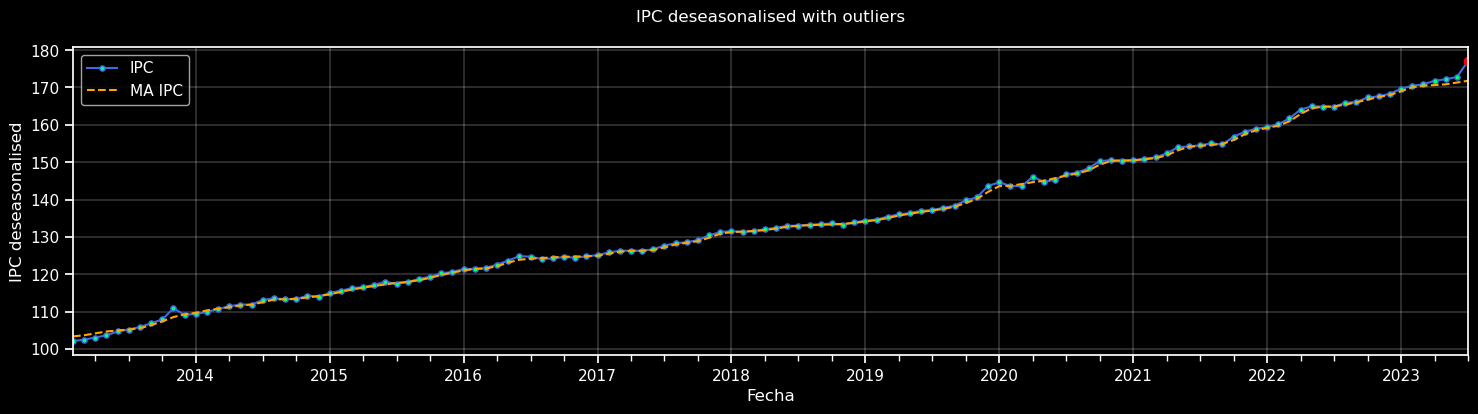

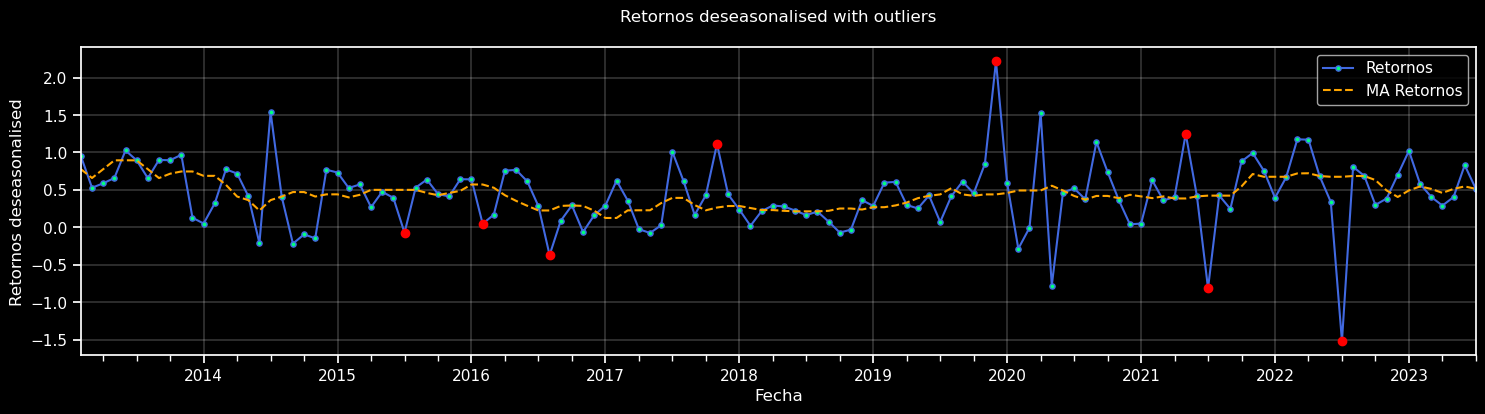

In [12]:
# Outliers en las series
df = series_with_outliers(data=data_deseasoned)

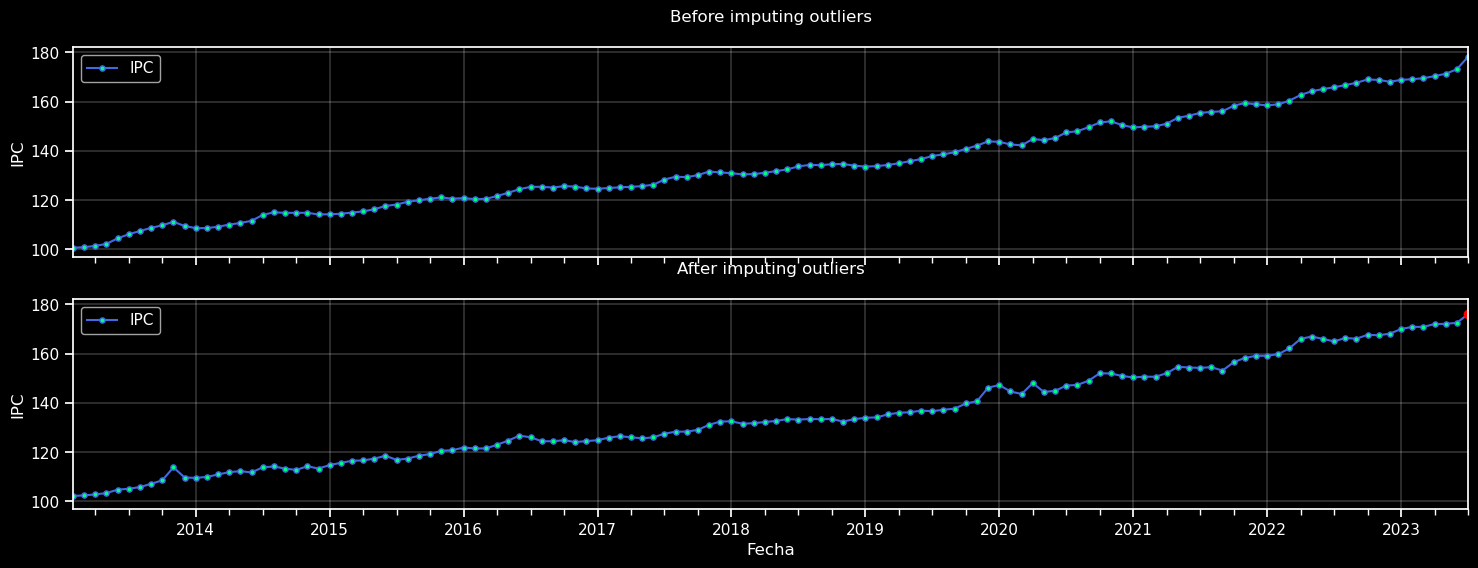

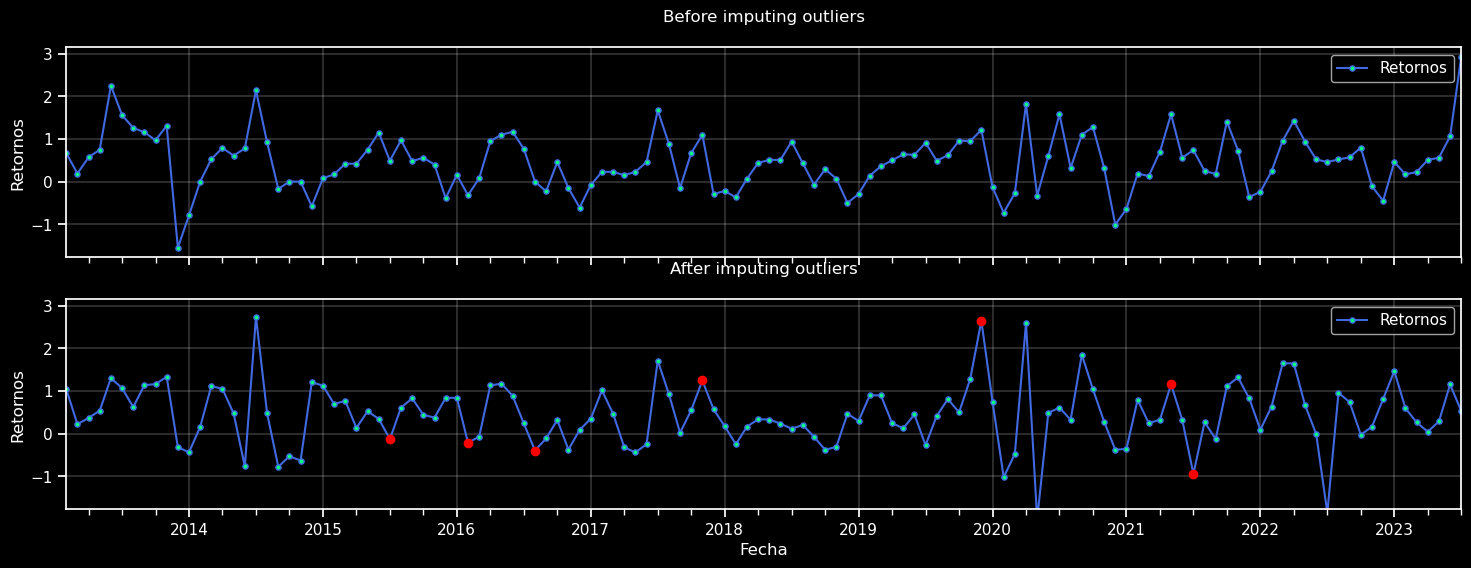

In [13]:
# Imputación de outliers
no_outliers = get_out_outliers(data_original=data,
                               data_transformada=df,
                               residuos=residuos,
                               methods=['linear', 'nearest'])

Como podemos ver, la mediana y la MAD son más robustas a los valores atípicos, no hay cambios bruscos en la mediana móvil ni en la MAD. Observamos que tanto la MAD como la desviación típica serán proporcionales a la inclinación de la tendencia. Por tanto, el método puede ser más sensible en áreas con una tendencia más plana: como podemos ver, una fluctuación más pequeña en los datos se identifica como un valor atípico. Una solución sencilla sería ajustar el umbral. 

### *Estacionariedad*

In [14]:
# Prueba de estacionariedad
adf_test(data=data)

Serie: IPC
P-value: 1.000
No se rechaza la hipótesis nula (la serie no es estacionaria) a un nivel de significancia del 5%

Serie: Retornos
P-value: 0.000
Se rechaza la hipótesis nula (la serie es estacionaria) a un nivel de significancia del 5%



In [15]:
# Transformar series a estacionarias y guardar el número de rezagos
series_estacionarias, num_diferenciaciones = get_stationarity(data=data)
num_diferenciaciones

{'IPC': 1, 'Retornos': 0}

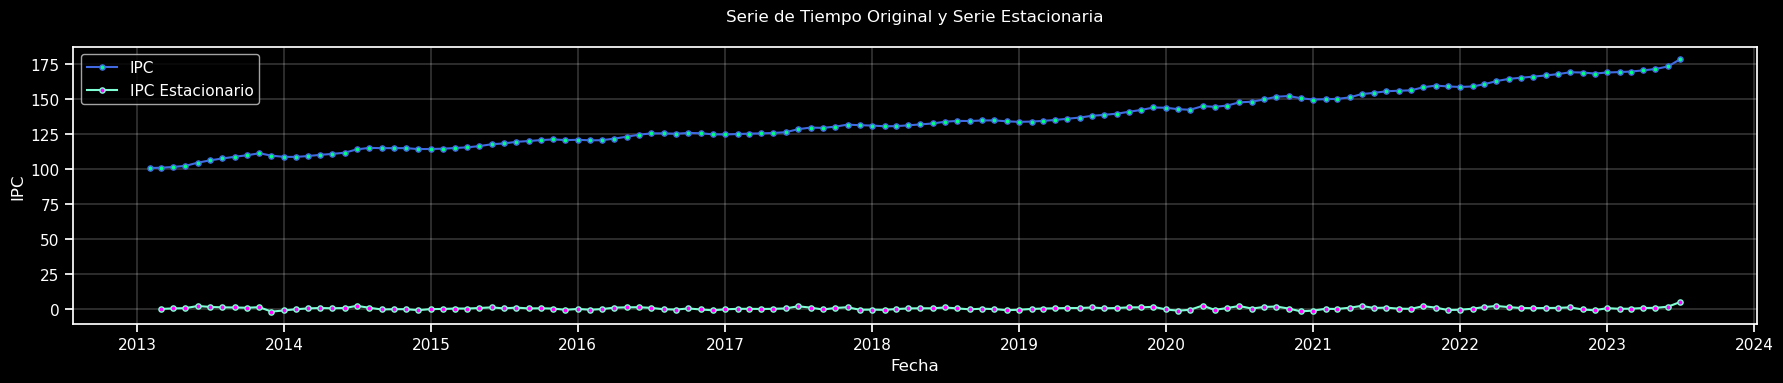

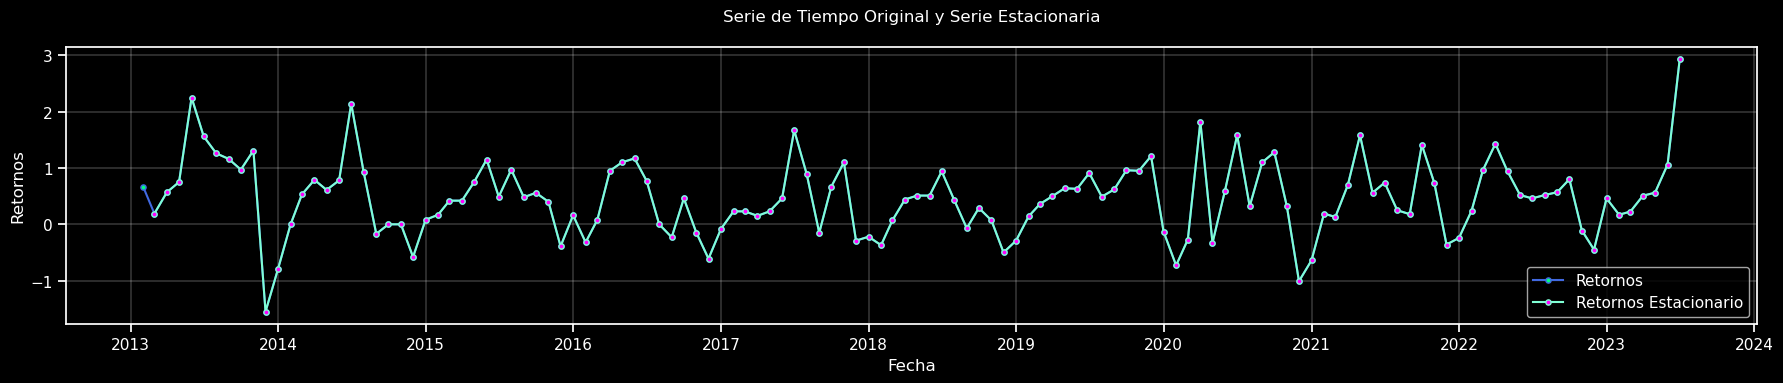

In [16]:
# Visualizar los cambios de estacionariedad en las series
time_series_behavior(data=data,
                     series_estacionarias=series_estacionarias)

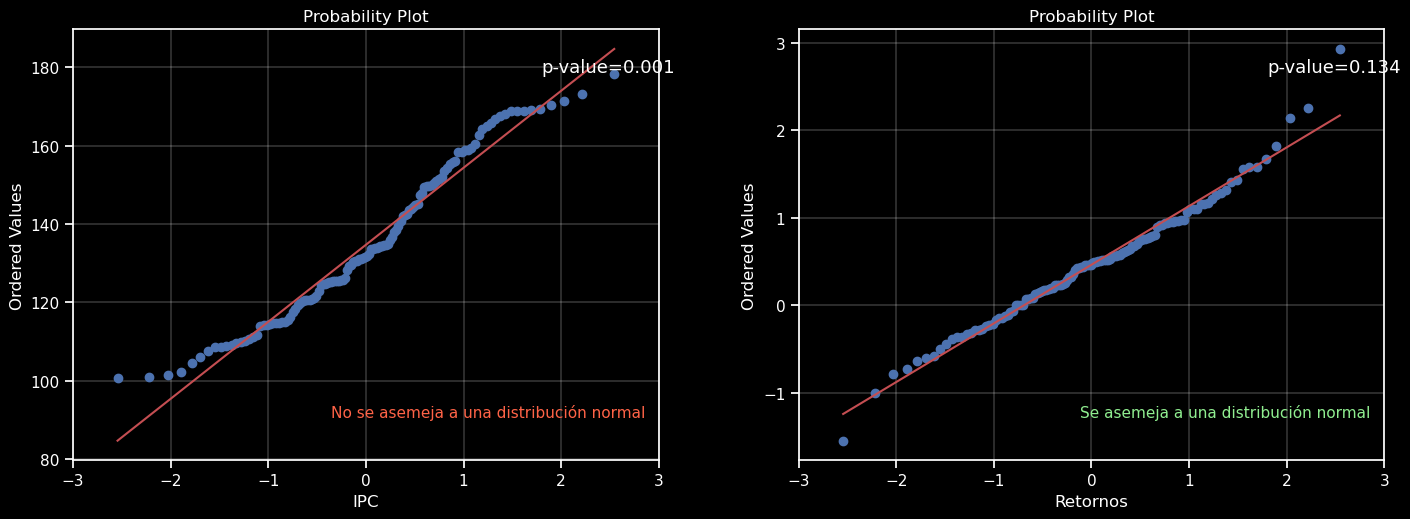

In [17]:
# Pruebad de normalidad
normality_test(data=data, 
               variables=data.columns.tolist())

In [18]:
# Prueba de homocedasticidad
homocedasticity_test(data=data)

Serie: IPC
Se rechaza la hipótesis nula de homocedasticidad (no es homocedástica) a un nivel de significancia del 5%

Serie: Retornos
No se rechaza la hipótesis nula de homocedasticidad (es homocedástica) a un nivel de significancia del 5%



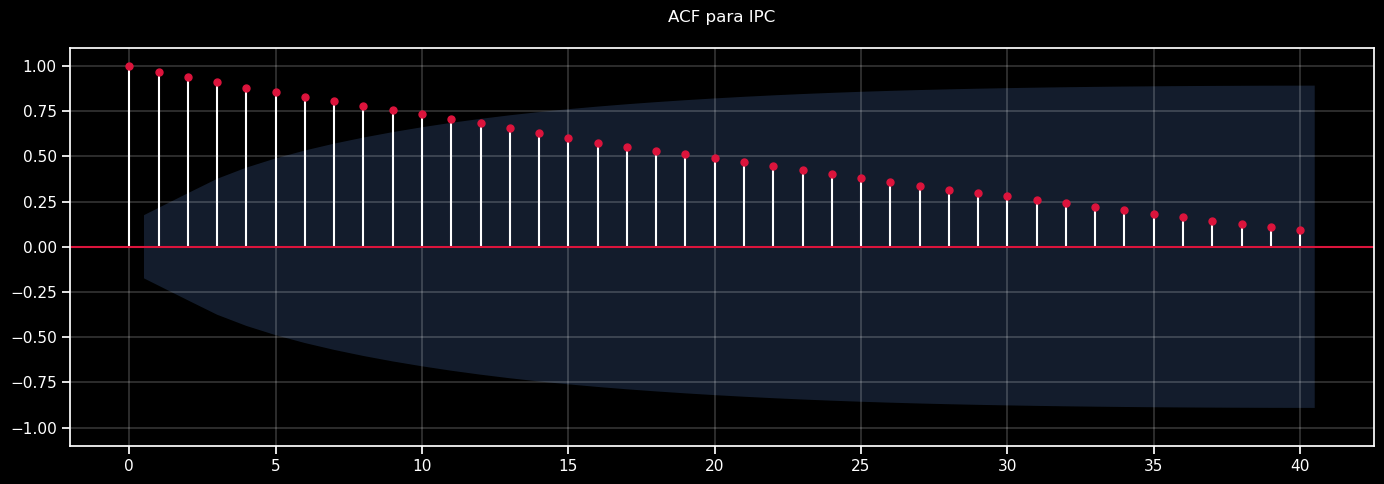

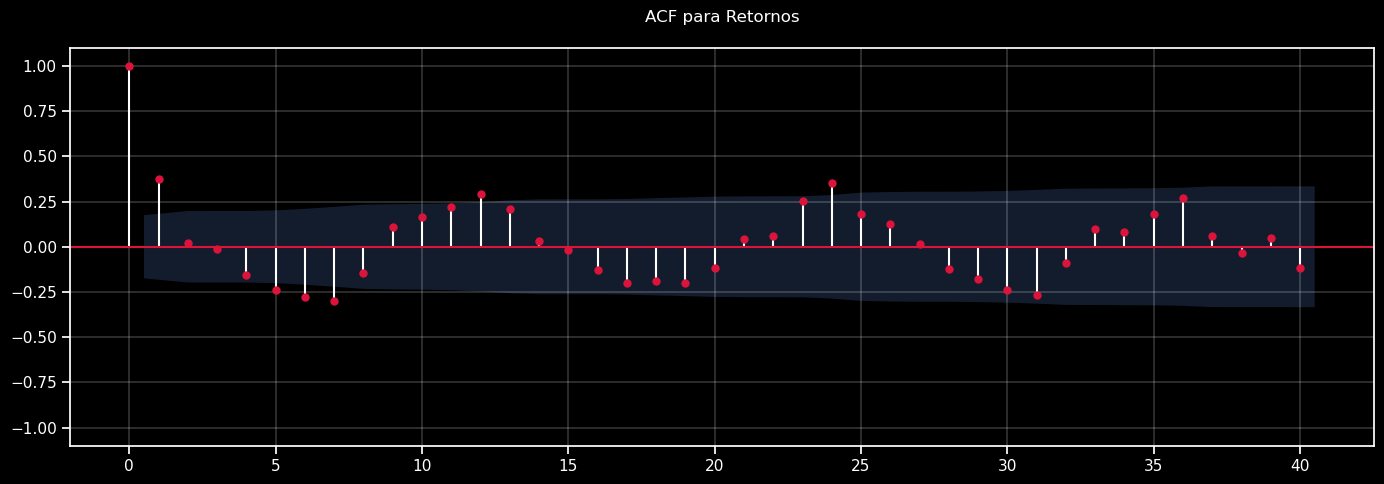

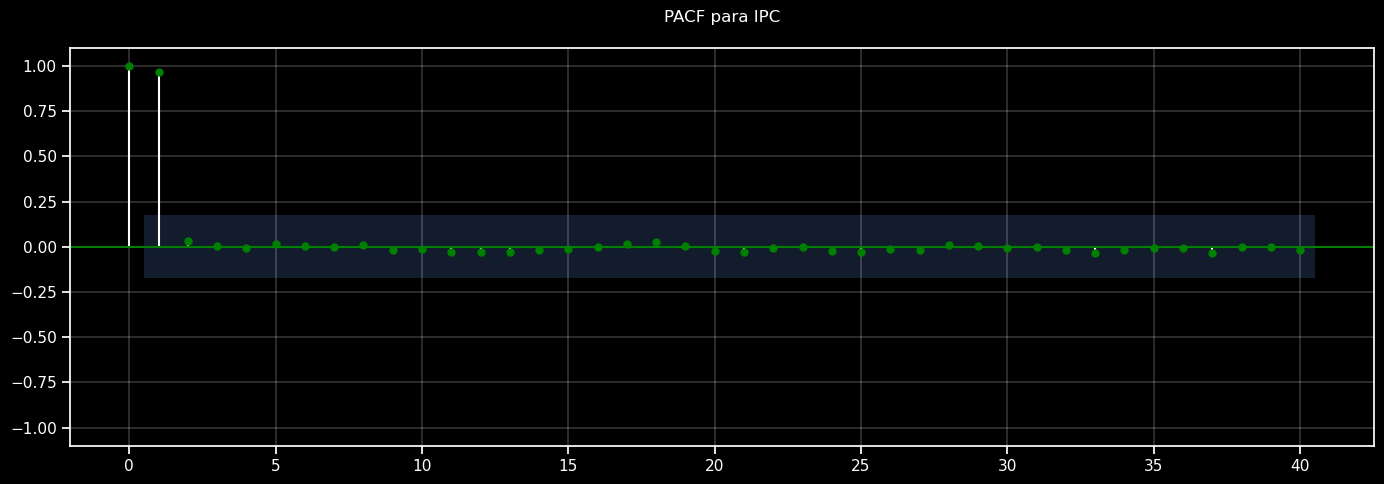

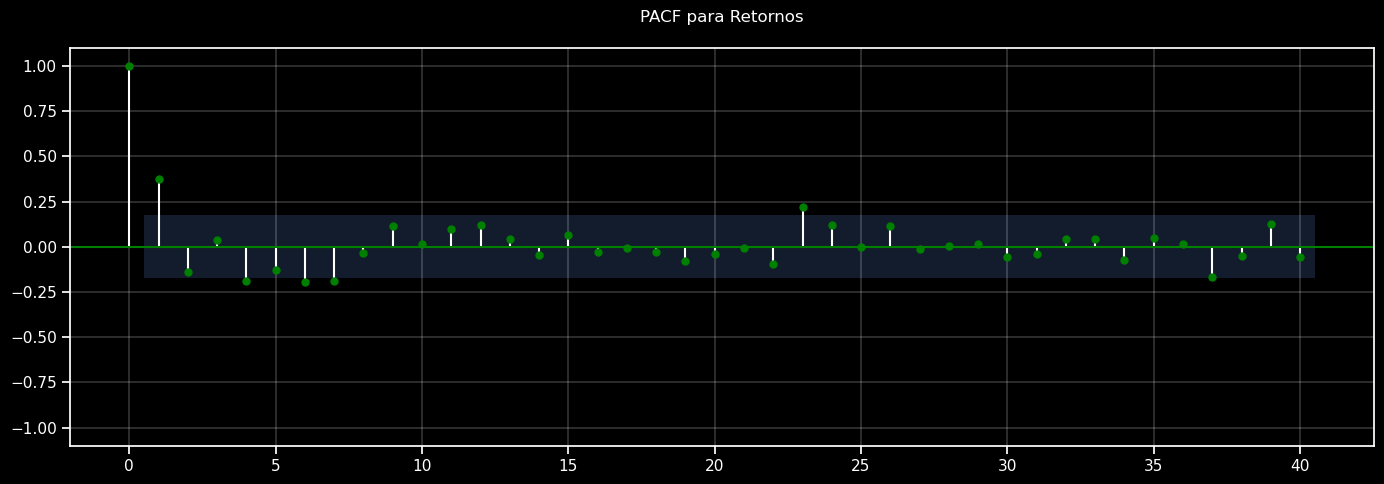

In [19]:
# Gráfico de función de autocorrelación y autocorrelación parcial
acf_y_pcf(data=data, lags=40)

In [20]:
# Creamos un diccionario para almacenar los conjuntos de entrenamiento y prueba
train_test_dict = dict()

# Definimos el tamaño de tu conjunto de prueba (por ejemplo, 20%)
test_size = 0.2

# Iteramos a través de las columnas del DataFrame
for serie in data.columns:
    series_tiempo = data[serie]
    n_test = int(len(series_tiempo) * test_size)
    train_data = series_tiempo[:-n_test]
    test_data = series_tiempo[-n_test:]
    
    train_test_dict[serie] = {'train': train_data, 
                              'test': test_data}

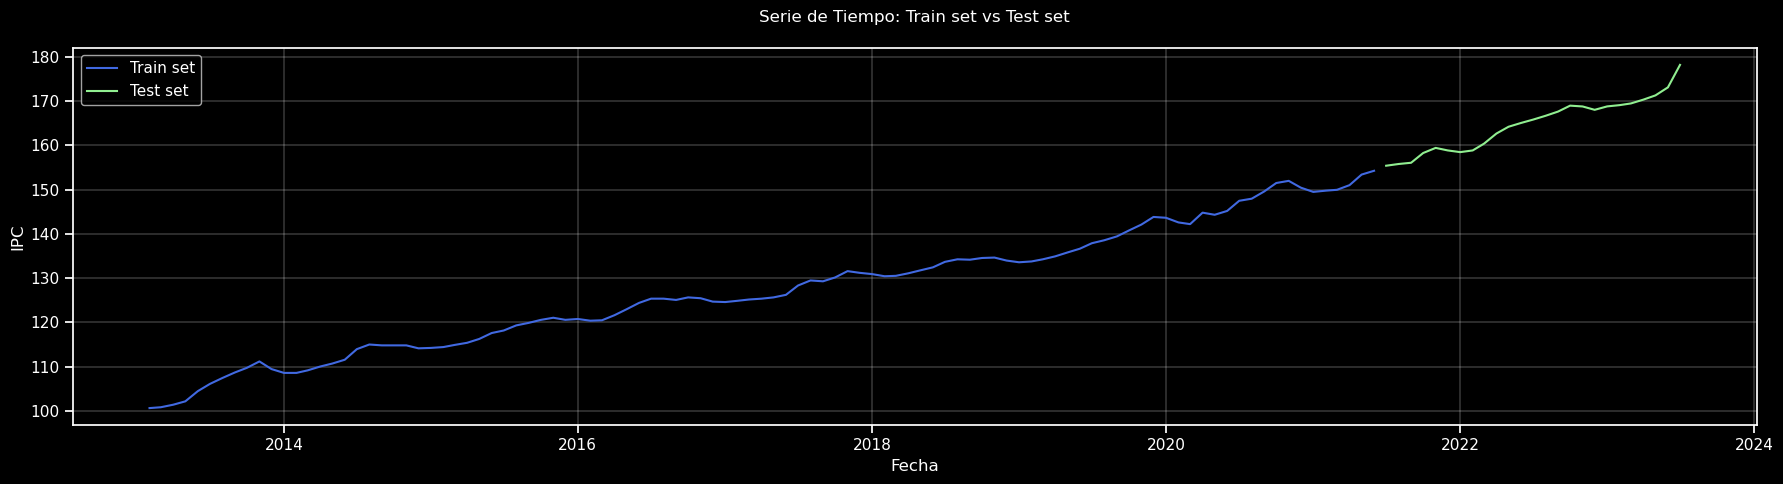

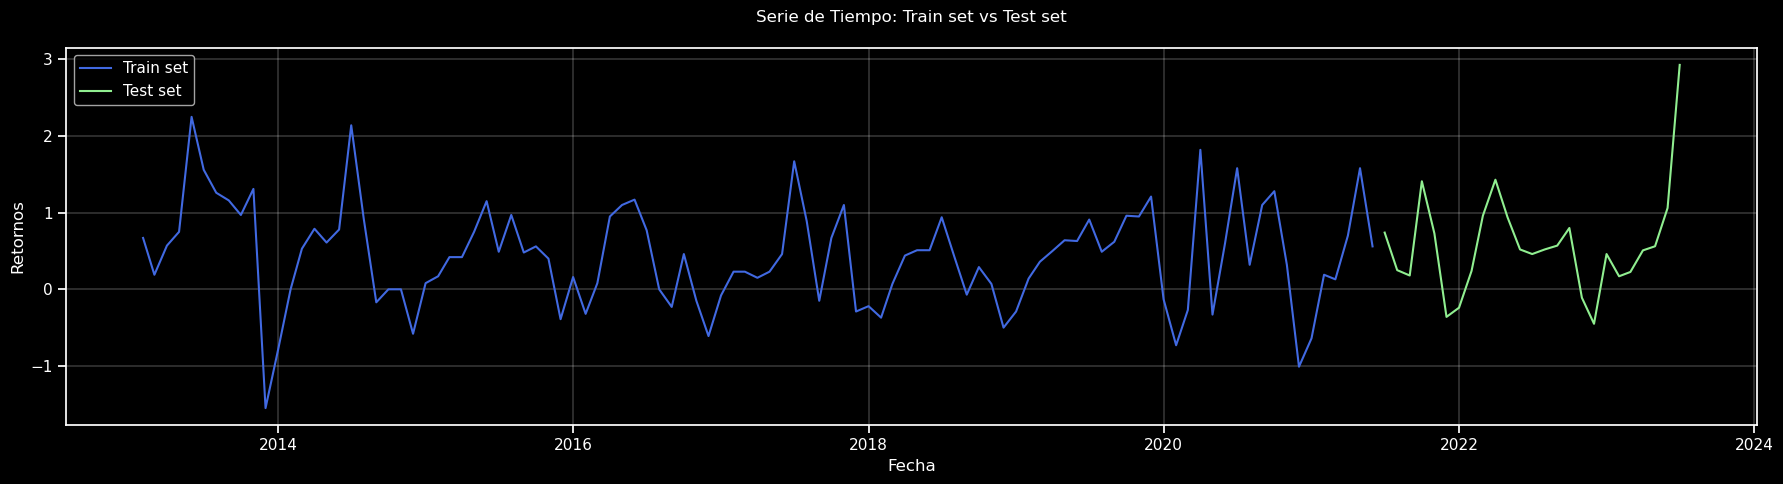

In [21]:
# Graficamos los datos de entrenamiento y prueba
for serie, datos in train_test_dict.items():
    train_data = datos['train']
    test_data = datos['test']
    
    plotting_train_test_pred(train_data=train_data, 
                             test_data=test_data)

In [22]:
from pmdarima import auto_arima

# AUTOARIMA resultados: p=0, d=1, q=2
# p -> Parámetro de orden autoregressivo
# d -> Parámetro de orden de integración
# q -> Parámetro de orden de media móvil

# Crear un diccionario para almacenar los modelos ARIMA
modelos_autoarima = dict()

# Iterar a través de las series de tiempo
for serie, datos in train_test_dict.items():
    train_data = datos['train']
    
    # Ajustar el modelo ARIMA utilizando auto_arima
    modelo_autoarima = auto_arima(train_data, seasonal=True, stepwise=True, trace=False,
                                  d=num_diferenciaciones[serie], start_p=0, 
                                  suppress_warnings=True, start_q=0, max_p=4, max_d=2, 
                                  max_q=4, start_P=0, D=1, start_Q=0, max_P=2, max_D=1, 
                                  max_Q=2, m=12, random_state=20, n_fits=50)
    
    # Almacenar el modelo ARIMA en el diccionario
    modelos_autoarima[serie] = modelo_autoarima

# Modelos ajustados 
modelos_autoarima

{'IPC': ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 1, 1, 12),
       suppress_warnings=True, with_intercept=False),
 'Retornos': ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 1, 12),
       suppress_warnings=True, with_intercept=False)}

In [24]:
# Crear un diccionario para almacenar las predicciones
autoarima_preds = dict()

# Iterar a través de las series de tiempo
for serie, modelo in modelos_autoarima.items():
    datos = train_test_dict[serie]
    train_data = datos['train']
    test_data = datos['test']
    
    # Realizar predicciones utilizando el modelo ARIMA
    preds = modelo.predict(test_data.shape[0])
    
    # Almacenar las predicciones en el diccionario con el nombre de la serie como clave
    autoarima_preds[serie] = {
        'modelo': modelo,
        'predicciones': preds
    }

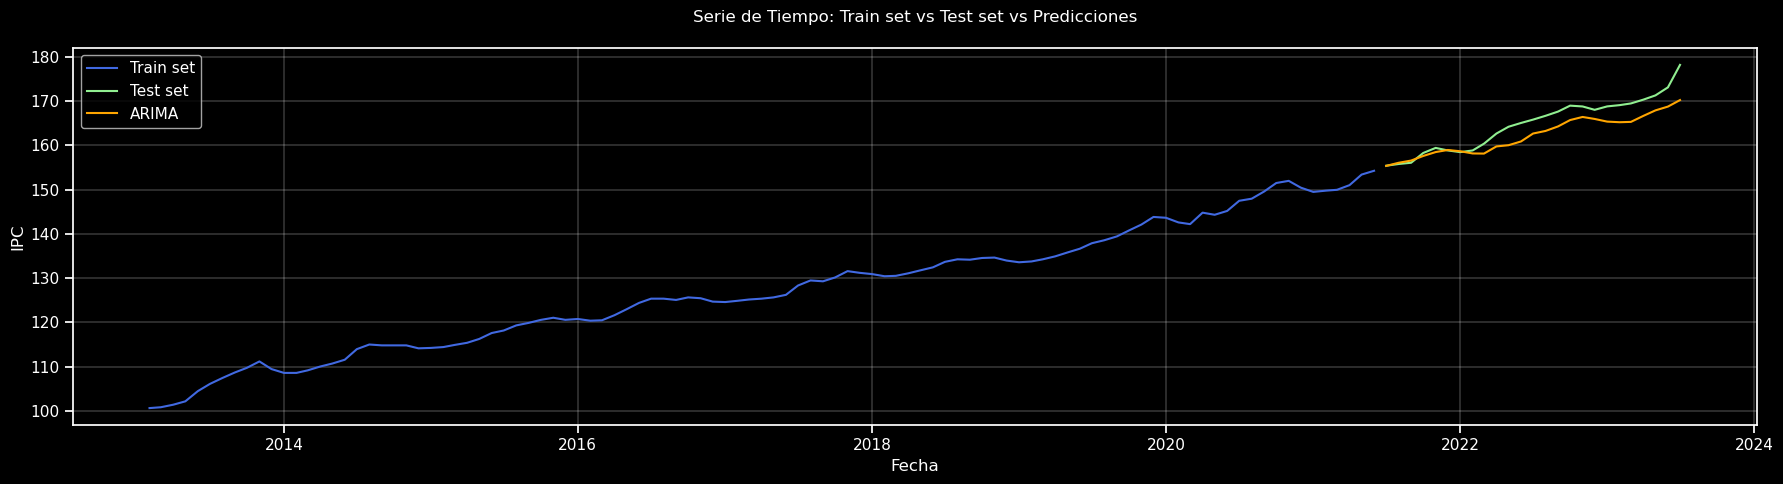

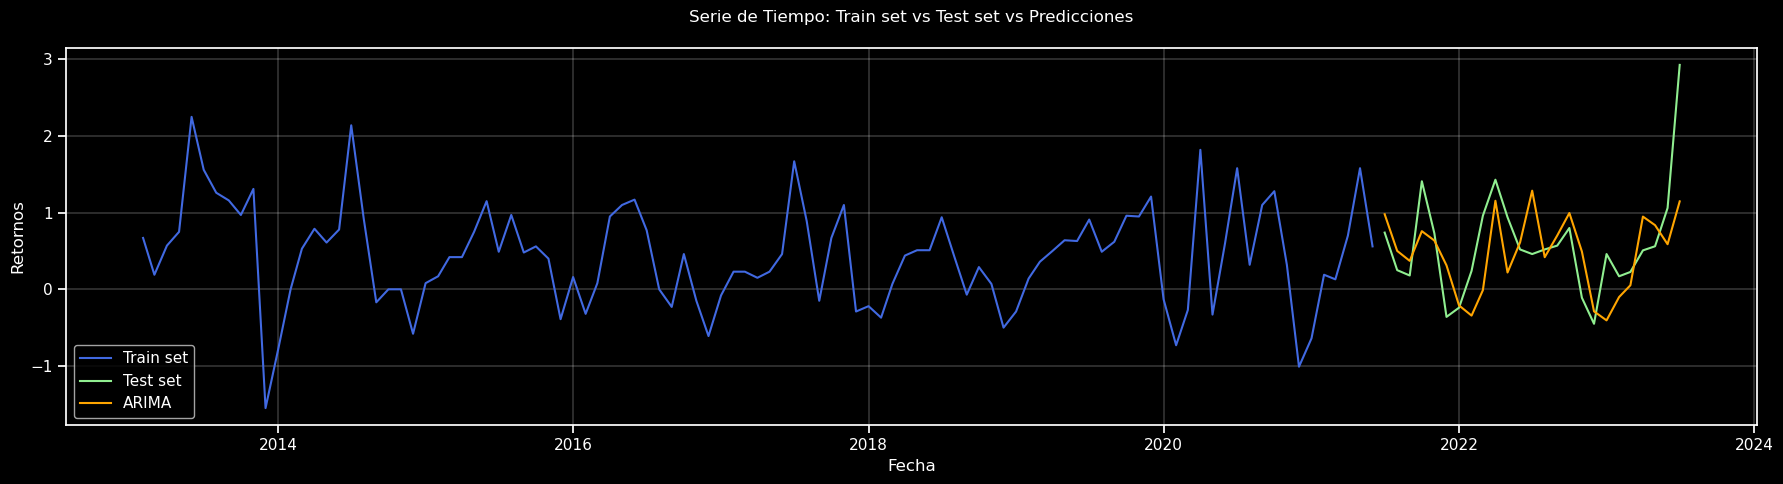

In [32]:
# Grafica los datos de entrenamiento, prueba y las predicciones
for serie, datos in train_test_dict.items():
    train_data = datos['train']
    test_data = datos['test']
    
    # Obtén las predicciones y el modelo para la serie actual
    modelo = autoarima_preds[serie]['modelo']
    preds = autoarima_preds[serie]['predicciones']
    
    plotting_train_test_pred(train_data=train_data, 
                             test_data=test_data,
                             modelo=modelo,
                             preds_data=preds)

In [37]:
# Resultados de las métricas de rendimiento
resultados = dict()

# Graficamos los datos de entrenamiento, prueba y las predicciones
for serie, datos in train_test_dict.items():
    test_data = datos['test']
    
    # Obtenemos las predicciones y el modelo para la serie actual
    preds = autoarima_preds[serie]['predicciones']
    modelo = autoarima_preds[serie]['modelo']

    resultados[serie] = evaluacion_metrica(y_true=test_data, 
                                           y_pred=preds, 
                                           modelo=modelo,
                                           serie_nombre=serie)

# Resultados de ambas series y sus modelos    
pd.concat([resultados['IPC'], resultados['Retornos']], axis=1)

,IPC,Retornos
Modelo,ARIMA,ARIMA
MSE,10.18,0.34
RMSE,3.19,0.59
MAE,2.61,0.44
MAPE,0.02,0.98
R²,0.71,0.24


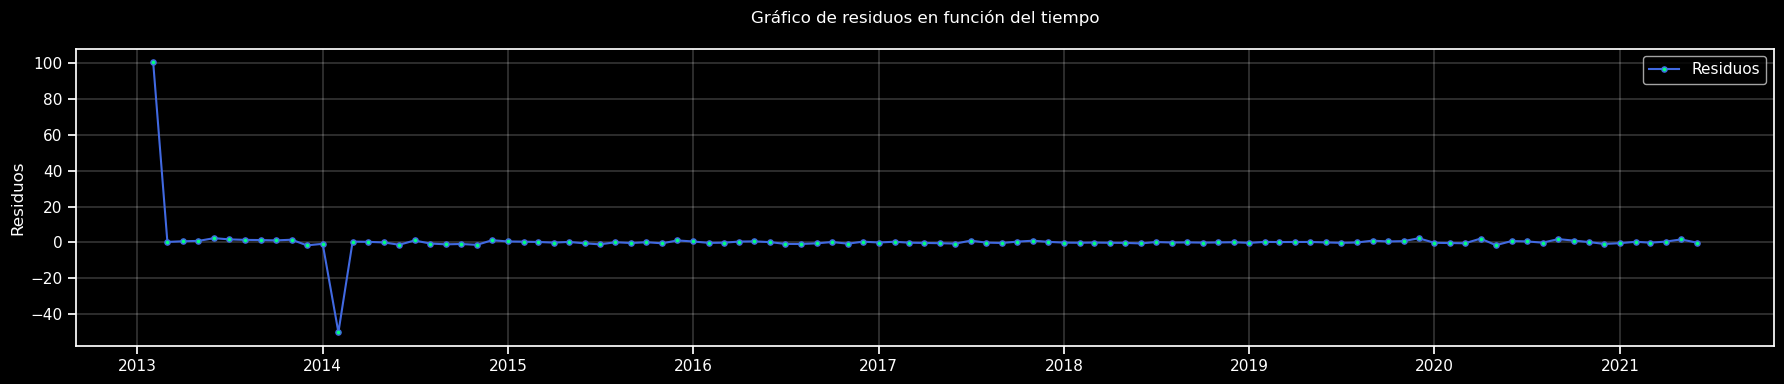

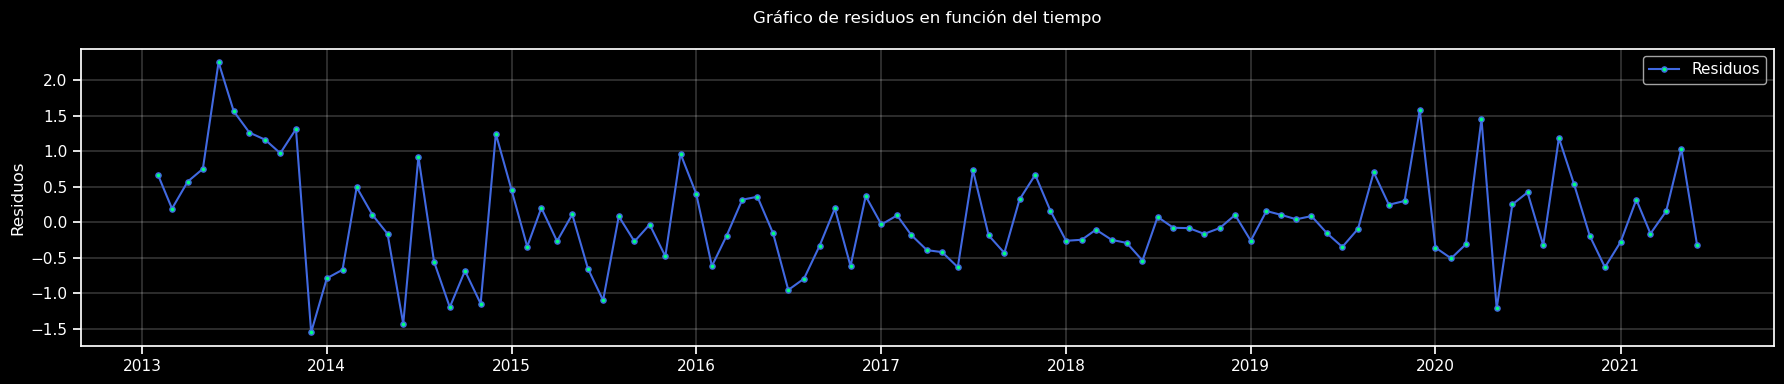

In [38]:
# Graficamos los residuos de las series de tiempo
for serie in data.columns:
    modelo = autoarima_preds[serie]['modelo']
    
    plotting_residuals(series=serie,
                       modelo=modelo)

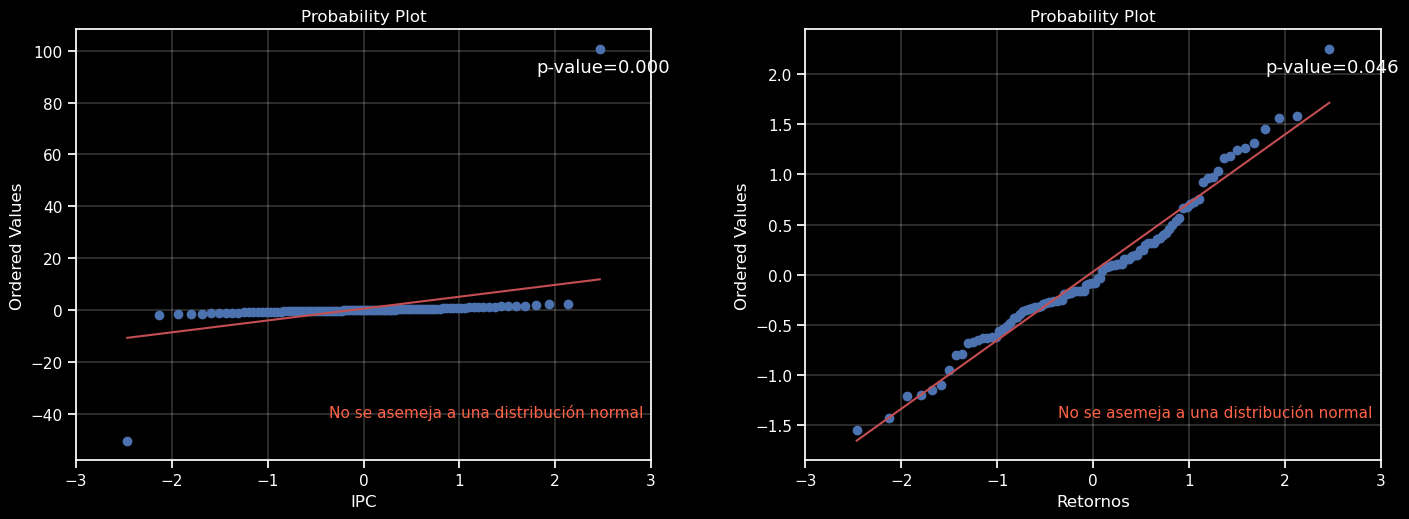

In [39]:
# Test de normalidad sobre los residuos con un nivel de significancia del 5%
residuos_modelos_autoarima = pd.concat({serie: autoarima_preds[serie]['modelo'].resid() for serie in autoarima_preds}, axis=1)

normality_test(data=residuos_modelos_autoarima,
               variables=residuos_modelos_autoarima.columns.tolist())

In [40]:
# Test de autocorrelación entre los residuos
autocorrelation_test(data=residuos_modelos_autoarima)

Serie: IPC
Los residuos no tienen autocorrelación a un nivel de significancia del 5%

Serie: Retornos
Los residuos no tienen autocorrelación a un nivel de significancia del 5%



In [41]:
# Test de jarque-bera entre los residuos
jarque_bera_test(data=residuos_modelos_autoarima)

Serie: IPC
Los residuos no parecen ruido blanco a un nivel de significancia del 5%

Serie: Retornos
Los residuos parecen ruido blanco a un nivel de significancia del 5%



In [ ]:
# Exportar datos sin outliers
no_outliers.to_csv('./datasets/interim/data_interim_mensual.csv', index=True)